# Pneumonia-Detection-with-CNN

Hildegard Zerrweck

The main purpose is to implement a Convolutional Neural Network (CNN) to detect pneumonia cases from the dataset, aiming to classify the images of X-rays in two classes: Normal, Pneumonia.

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from sklearn.metrics import classification_report
import time
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as model_selection

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. All images are pre-processed into 28x28 (2D) or 28x28x28 (3D) with the corresponding classification labels.

In [2]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [3]:
import medmnist
from medmnist import INFO

In [4]:
DATASET_NAME = "pneumoniamnist"
info = INFO[DATASET_NAME]
print(info)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [5]:
DataClass = getattr(medmnist, info["python_class"])

In this part we prepare the data subset: training (train_ds), validation (val_ds) and testing (test_ds).

In [6]:
train_ds = DataClass(split = "train", download = True, as_rgb = False)
val_ds = DataClass(split = "val", download = True, as_rgb = False)
test_ds = DataClass(split = "test", download = True, as_rgb = False)

This is an auxiliar function to transform the data into NumPy arrays, which facilitates the preprocessing and posterior training.

In [7]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for i in range(len(dataset)):
        img, label = dataset[i]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels).squeeze()

The previous function "dataset_to_numpy" converts each subset into NumPy tensors, then we call the function with each respective parameters.

In [8]:
x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)
x_test, y_test = dataset_to_numpy(test_ds)


Then, we normalize the pixels values in order to keep them in a [0,1] range. This helps to keep a numerical stability during the training.

In [9]:
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

This cell helps to display some images from the dataset in order to verify that our data is correctly loaded and to help us understand how they look.

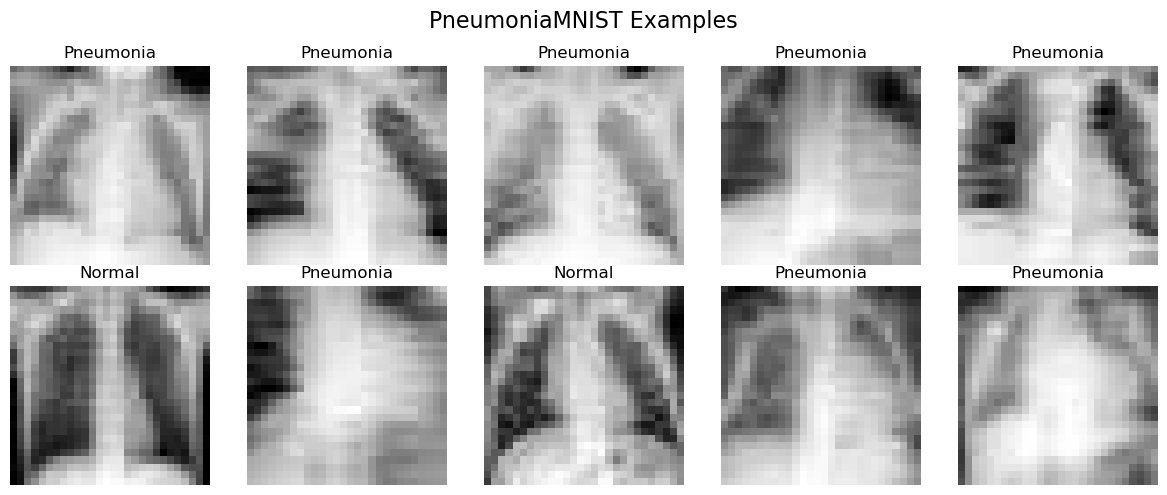

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("PneumoniaMNIST Examples", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = x_train[i].squeeze()  
    label = y_train[i]
    ax.imshow(img, cmap="gray")
    ax.set_title("Normal" if label == 0 else "Pneumonia")
    ax.axis("off")

plt.tight_layout()
plt.show()

Convert the image arrays and labels into TensorFlow optimized datasets in order to begin training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64

In [12]:
def prep_example(x, y):
    x = tf.cast(x, tf.float32) / 255.0 #normalization: images to [0,1]
    x = tf.reshape(x, [28,28,1])
    y = tf.cast(y, tf.int32) # labels as integers
    return x, y

The cell below constructs the data pipelines for training, validation and testing in order to manage the images in a more efficient way, using batches and paralelism, optimizing the CPU/GPU training.

In [13]:
train_tf = (tf.data.Dataset.from_tensor_slices((x_train, y_train)) # converts arrays [image, label] into a Dataset object
            .map(prep_example, num_parallel_calls=AUTOTUNE) #applies prep_example function listeed above this   cell.
            .shuffle(10_000) # just in training, mix ramndomly 10,000 examples in a buffer to avoid pattern recognition into the model.
            .batch(BATCH) # groups examples into batches with a defined size.
            .prefetch(AUTOTUNE)) # this allows tensorflow to prepare the following batch whilde CPU/GPU trains the current batch.

val_tf = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
          .map(prep_example, num_parallel_calls=AUTOTUNE)
          .batch(BATCH)
          .prefetch(AUTOTUNE))

test_tf = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .map(prep_example, num_parallel_calls=AUTOTUNE)
           .batch(BATCH)
           .prefetch(AUTOTUNE))

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

At this point, we define the convolutional neural network based on **LeNet-5** architecture, adapted to work with **PneumoniaMNIST** dataset (28x28 images in grey scale, 2 labels)

In [15]:
model = keras.Sequential([
    # C1: Convolutional layer
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1),
                  padding='same', activation='tanh',
                  input_shape=(28, 28, 1)),

    # S2: Subsampling / Pooling Layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),

    # C3: Convolutional Layer
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1),
                  padding='valid', activation='tanh'),

    # S4: Subsampling / Pooling Layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),

    # C5 + F6: Fully connected layers
    layers.Flatten(),
    layers.Dense(120, activation='tanh'),
    layers.Dense(84,  activation='tanh'),

    # Output (2 clases): binary classification
    layers.Dense(2, activation='softmax')
])

C:\Users\zerrw\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# defining hyperparameters
n_epochs=25
n_batch=64
learning_rate=0.01
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Once our architecture is define, we proceed to **compile** the model, this means to specify how the network is going to be trained, according tho the hyperparameters defined at the previous cell.

I am using Adam because it combines the benefits from AdaGrad and RMSProp, adjusting dynamically the learning rate of each parameter, this is one of the most used optimizers for CNN.

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',  # <— clave
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,026 (238.38 KB)

 Trainable params: 61,026 (238.38 KB)

 Non-trainable params: 0 (0.00 B)

After compiling the model, 'model.summary()' gives us a detailed view of each layer, output form and number of trainable parameters.
This model is relatively **light** because of its 61k parameters, which makes it efficient to train not-large datasets.
Convolutional layers extract special features from the images, by the other side, *pooling* reduces dimensionality and dense layers learn more abstract representations to classify the binary label.

Once the model is compiled, we train it using the `fit()` function.  
This step runs the optimization process: feeding batches of training data through the network, updating weights, and evaluating on the validation set at the end of each epoch.

In [ ]:
history = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=25,            
    verbose = 1
)

Epoch 1/25


In [ ]:
# Despliega las curvas de aprendizaje
H = history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

The training process was monitored using accuracy and loss curves for both the training and validation sets.  

**Accuracy:** both training and validation show a rapid increase during the first epochs. After ~5, we can observe how accuracy stanbilies abobe 90%. The closeness of both curves suggests that the model generalizes well and does not suffer from severe overfitting.

**Loss:** Training and validation decreaase sharply during the first epochs, after ~5 epochs, the curves flatten, converging towards very low loss values. Training loss continues to drop slightly lower than validation loss, which is expectes as the model optimizes on training data.

The model learns very quickly, achieving strong performance within the first 5–10 epochs, we observe high accuracy and low loss on both training and validation sets demonstrate that the CNN (LeNet-5 inspired) is well-suited for the PneumoniaMNIST dataset. The small gap between training and validation metrics suggests a balanced model that avoids underfitting and overfitting.  


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

The classification report provides detailed metrics for each class (*Normal* vs *Neumonía*) on the test set.

In [ ]:
y_true = np.concatenate([y for _, y in test_tf], axis=0)
y_prob = model.predict(test_tf)
y_pred = y_prob.argmax(axis=1)
labels = ["Normal", "Neumonía"]
print(classification_report(y_true, y_pred, target_names=labels))


### Classification Report

The classification report provides detailed metrics for each class (*Normal* vs *Neumonía*) on the test set.

**Normal (234 samples)**  
   Precision:  When the model predicts "Normal", it is correct 98% of the time.  
   Recall:  The model only identifies 60% of the actual "Normal" cases, missing 40%.  
   F1-score: Balanced metric showing strong precision but weaker recall.  
**Neumonía (390 samples)**  
   Precision: When predicting "Neumonía", 80% of those predictions are correct.  
   Recall: The model is extremely sensitive to detecting pneumonia, capturing almost all cases.  
   F1-score: Good balance between precision and recall.  

**Accuracy:** The model classifies 84% of the test samples correctly.  
**Macro Avg (balanced classes):** Precision 0.89, Recall 0.80, F1-score 0.82.  
**Weighted Avg (considering class imbalance):** Precision 0.87, Recall 0.84, F1-score 0.83.  

The model is **very strong at detecting pneumonia** (high recall = 0.99), which is desirable in medical settings where missing a pneumonia case is critical, however, it struggles to correctly classify "Normal" cases (recall = 0.60), meaning it often labels healthy patients as having pneumonia (false positives).  This trade-off shows the model prioritizes **sensitivity (recall for pneumonia)** over **specificity (recall for normal)**.  
The CNN performs well overall, especially in identifying pneumonia cases. Future improvements could focus on increasing recall for "Normal" without sacrificing the excellent pneumonia detection rate.


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - PneumoniaMNIST")
plt.show()

The confusion matrix shows how well the model distinguishes between *Normal* and *Pneumonia* cases.
The model performs exceptionally well at detecting Pneumonía: out of 390 actual pneumonia cases, 387 were correctly identified (recall ≈ 0.99), only 3 pneumonia cases were missed (false negatives).  
On the other hand, performance for Normal cases is weaker:  out of 234 actual normal cases, only 144 were correctly classified, 90 were incorrectly labeled as pneumonia (false positives). 